# Download and Unzip Dataset 

In [10]:
!unzip Dataset.zip

Archive:  Dataset.zip
   creating: Dataset/
   creating: Dataset/walking/
  inflating: Dataset/walking/person01_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person01_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person02_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d3_uncomp.avi  
  inflating: Dataset/walking/person03_walking_d4_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d1_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d2_uncomp.avi  
  inflating: Dataset/walking/person04_walking_d3_uncomp.av

# Import Required Libraries

In [3]:
!pip install pafy youtube-dl moviepy

In [4]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import seaborn as sns

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

2023-06-19 10:15:32.067581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Select Randomness

In [5]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# View the dataset

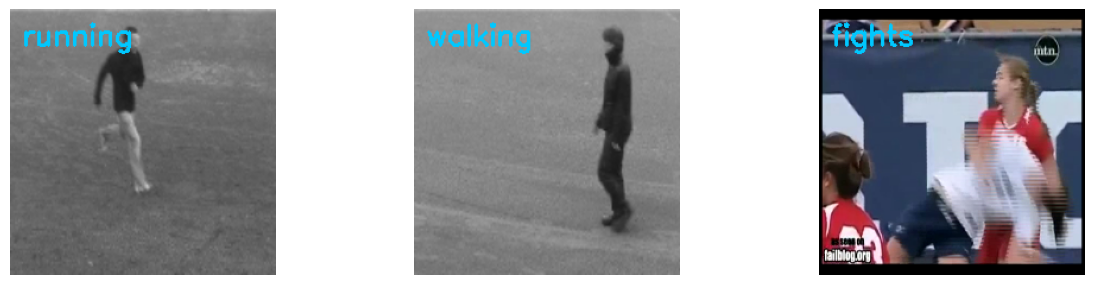

In [11]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))
 
# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('Dataset')
 
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
# random_range = random.sample(range(len(all_classes_names)), len(all_classes_names))
 
# Iterating through all the generated random values.
for counter, random_index in enumerate(range(len(all_classes_names)), 1):
 
    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
 
    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'Dataset/{selected_class_Name}')
 
    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
 
    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'Dataset/{selected_class_Name}/{selected_video_file_name}')
    video_reader.set(1, 25)

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()
  
    bgr_frame = cv2.resize(bgr_frame ,(224,224))
    # Release the VideoCapture object. 
    video_reader.release()
 
    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
 
    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')


# Set Dataset Variables

In [12]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
 
# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 30
 
# Specify the directory containing the UCF50 dataset. 
DATASET_DIR = "Dataset"
 
# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["walking", "fights", "running"]

# Data pre-processing

In [13]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [14]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [15]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: walking
Extracting Data of Class: fights
Extracting Data of Class: running


In [16]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

In [17]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# Model Creation LRCN (Long-term Recurrent Convolutional Network)

In [18]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()
    
    # Define the Model Architecture.
    ########################################################################################################################
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()
    
    # Return the constructed LRCN model.
    return model

In [19]:
model = create_LRCN_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 64, 64, 32)   896       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 16, 16, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 16, 16, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 4, 4, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 4, 4, 128)    7

2023-06-19 10:24:06.047520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 10:24:06.051249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 10:24:06.053033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [ ]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Model Training

In [20]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)
 
# Compile the model and specify loss function, optimizer and metrics to the model.
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
 
# Start training the model.
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/70


2023-06-19 10:24:07.133230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 10:24:07.136006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 10:24:07.138097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - ETA: 0s - loss: 0.8578 - accuracy: 0.4765

2023-06-19 10:24:19.242270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-19 10:24:19.244733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-19 10:24:19.246873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

43/43 [==============================] - 14s 228ms/step - loss: 0.8578 - accuracy: 0.4765 - val_loss: 0.4799 - val_accuracy: 0.7018
Epoch 2/70
43/43 [==============================] - 8s 196ms/step - loss: 0.5255 - accuracy: 0.6588 - val_loss: 0.4686 - val_accuracy: 0.7018
Epoch 3/70
43/43 [==============================] - 8s 182ms/step - loss: 0.5042 - accuracy: 0.6647 - val_loss: 0.5904 - val_accuracy: 0.5965
Epoch 4/70
43/43 [==============================] - 9s 200ms/step - loss: 0.6467 - accuracy: 0.5647 - val_loss: 0.5384 - val_accuracy: 0.6140
Epoch 5/70
43/43 [==============================] - 8s 196ms/step - loss: 0.5153 - accuracy: 0.6588 - val_loss: 0.4823 - val_accuracy: 0.7018
Epoch 6/70
43/43 [==============================] - 10s 226ms/step - loss: 0.4977 - accuracy: 0.6353 - val_loss: 0.4863 - val_accuracy: 0.6316
Epoch 7/70
43/43 [==============================] - 8s 176ms/step - loss: 0.5017 - accuracy: 0.6353 - val_loss: 0.4914 - val_accuracy: 0.6316
Epoch 8/70
43/4

# Save Model

In [ ]:
# Save your Model.
model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

# Plot Loss and Accuracy Graphs while Training

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation 
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()

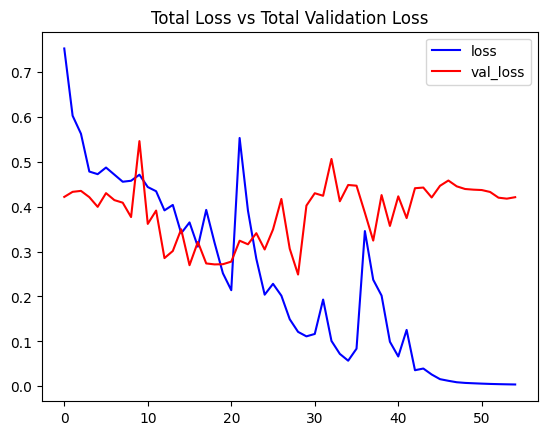

In [ ]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

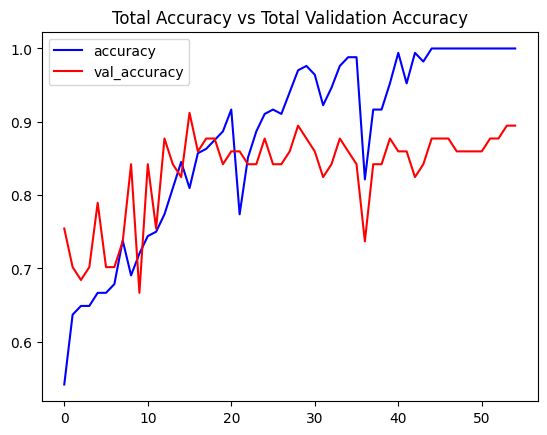

In [ ]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
features_test

array([[[[[0.64705882, 0.64705882, 0.64705882],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.65490196, 0.65490196, 0.65490196],
          ...,
          [0.64705882, 0.64705882, 0.64705882],
          [0.6627451 , 0.6627451 , 0.6627451 ],
          [0.64705882, 0.64705882, 0.64705882]],

         [[0.56470588, 0.56470588, 0.56470588],
          [0.59607843, 0.59607843, 0.59607843],
          [0.57254902, 0.57254902, 0.57254902],
          ...,
          [0.61176471, 0.61176471, 0.61176471],
          [0.6       , 0.6       , 0.6       ],
          [0.58823529, 0.58823529, 0.58823529]],

         [[0.58039216, 0.58039216, 0.58039216],
          [0.60392157, 0.60392157, 0.60392157],
          [0.57254902, 0.57254902, 0.57254902],
          ...,
          [0.55686275, 0.55686275, 0.55686275],
          [0.56862745, 0.56862745, 0.56862745],
          [0.58431373, 0.58431373, 0.58431373]],

         ...,

         [[0.49411765, 0.49411765, 0.49411765],
          [0.54117647,

In [ ]:
labels_test

array([[1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0

# Accuracy on Test Dataset

In [ ]:
act = np.array([])
pred = np.array([])
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])

  act = np.append(act,actual_label)
  pred = np.append(pred,predicted_label)
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)


2023-06-16 20:32:56.339042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-16 20:32:56.341420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-16 20:32:56.343270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 35ms/step
Accuracy = 86.66666666666667


<Axes: >

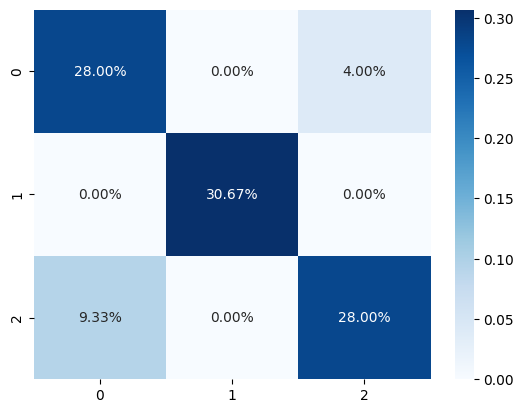

In [ ]:
cf_matrix = confusion_matrix(act,pred)
# cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

# cm_display.plot()
# plt.show()
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [ ]:
def calculate_metrics(actual, predicted, label):
    TP = np.sum((actual == label) & (predicted == label))
    FP = np.sum((actual != label) & (predicted == label))
    FN = np.sum((actual == label) & (predicted != label))
    TN = np.sum((actual != label) & (predicted != label))

    accuracy = (TP+TN)/(TP+TN+FP+FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1_score, accuracy

for i in range(3):
    label_of_interest = i  # Specify the label of interest
    precision, recall, f1_score, accuracy = calculate_metrics(act, pred, label_of_interest)
    print("Precision for Label", label_of_interest, ":", precision)
    print("Recall for Label", label_of_interest, ":", recall)
    print("F1 Score for Label", label_of_interest, ":", f1_score)
    print("accuracy for Label", label_of_interest, ":", accuracy)
    print("\n")

Precision for Label 0 : 0.75
Recall for Label 0 : 0.875
F1 Score for Label 0 : 0.8076923076923077
accuracy for Label 0 : 0.8666666666666667


Precision for Label 1 : 1.0
Recall for Label 1 : 1.0
F1 Score for Label 1 : 1.0
accuracy for Label 1 : 1.0


Precision for Label 2 : 0.875
Recall for Label 2 : 0.75
F1 Score for Label 2 : 0.8076923076923077
accuracy for Label 2 : 0.8666666666666667


